<h1><center>Opmatch</center>
</h1>

<center>A lightweight package for optimal case-control matching.</center>

<h3 align="center">
    <a href="#-quick-tour">Quick Tour</a> &bull;
    <a href="#%EF%B8%8F-getting-started">Getting Started</a>
</h3>

## ⚡️ Getting Started
-------------------------

```bash
pip install opmatch
```
or
```bash
conda install -c conda-forge opmatch
```

## 🚀 Quick Tour
----------------------------------

### Generate Data

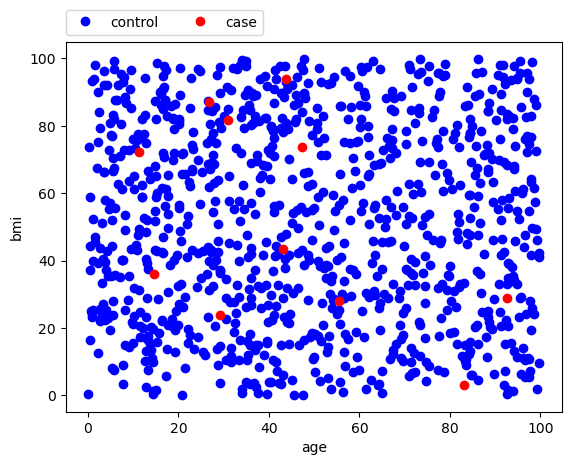

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

num_patients = 1000
age = np.random.uniform(0, 100, num_patients)
bmi = np.random.uniform(0, 100, num_patients)
case = np.random.binomial(1, .01, num_patients)
df = pd.DataFrame({'age':age, 'bmi':bmi, 'case':case})

plt.plot(df.age[df.case==0], df.bmi[df.case==0], 'bo', label='control')
plt.plot(df.age[df.case==1], df.bmi[df.case==1], 'ro', label='case')
plt.xlabel('age')
plt.ylabel('bmi')
plt.legend(loc=(0,1.02), ncol=2)

## Perform matching

In [99]:
from typing import List
import warnings
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
from sklearn.linear_model import LogisticRegression

class Matcher:
    def __init__(self, df:pd.DataFrame, matching_ratio:int=None, min_mr:int=None, 
        max_mr:int=None, n_controls:int=None, metric:str='PS',
        var_cols:List[str]=None, case_col:str='case', ps_col:str=None,
        matching_type:str='const') -> None:
        """matching_ratio: number of controls per case if constant matching ratio
        min_mr: minimum number of controls per case
        max_mr: maximum number of controls per case
        matching_type: 'const' or 'variable'
        var_cols: if metric is not PS, columns that will be used for matching
        case_col: column name of case column, should contain 1s and 0s
        From here on we follow the notation from the paper:
            A note on optimal matching with variable controls using the assignment algorithm
            alpha:=min_mr (minimal number of controls per case)
            beta:=max_mr (maximal number of controls per case)
            n:=num_cases
            m:=num_controls (total number of controls to match)
            M:=n_control_pool (number of available controls)
            K= n*beta - m
        """
        df[case_col] = df[case_col].astype(bool)
        self.df = df
        self.n = int(self.df[case_col].sum()) # number of cases
        if matching_type in ['const', 'constant', 'Constant']:
            assert isinstance(matching_ratio, int), 'Pass an integer to matching_ratio'
            self.alpha = matching_ratio
            self.beta = matching_ratio
            self.m = matching_ratio*self.n 
        elif matching_type in ['variable', 'Variable', 'var']:
            assert isinstance(min_mr, int), 'Pass an integer to min_mr'
            assert isinstance(max_mr, int), 'Pass an integer to max_mr'
            assert isinstance(n_controls, int), 'Pass an integer to n_controls'
            self.alpha = min_mr
            self.beta = max_mr
            self.m = n_controls
        else:
            raise ValueError(f'Unknown matching_type={matching_type}')

        self.metric = metric
        self.case_col = case_col
        if isinstance(var_cols, type(None)) and not metric in ['PS', 'ps']:
            self.check_var_cols()
            
        self.var_cols = var_cols
        self.ps_col = ps_col
        case_mask = self.df[self.case_col]
        self.M = (~case_mask).sum() 
        self.df_case = self.df[case_mask]
        self.df_control = self.df[~case_mask]
        self.case_ids = self.df_case.index
        self.control_ids = self.df_control.index
        print(f'Number of cases: {self.n}')
        print(f'Size of the control pool: {self.M}')
        print(f"alpha={self.alpha}, beta={self.beta}, M={self.M}, m={self.m}, n={self.n}")
    def match(self):
        self.check_parameters()
        if self.metric=='PS' or self.metric=='ps':
            if isinstance(self.ps_col, type(None)):
                if 'ps' in self.df.columns:
                    self.ps_col = 'ps'
                elif 'PS' in self.df.columns:
                    self.ps_col = 'PS'
                else:
                    warnings.warn("Propensity score column name not passed, and 'ps'/'PS' not found in df, perform logistic regression on var_cols, to compute ps")
                    self.compute_ps()
                    self.ps_col = 'ps'
            X_case = self.df_case[self.ps_col].to_numpy().reshape(-1,1)
            X_control = self.df_control[self.ps_col].to_numpy().reshape(-1,1)
            self.metric = 'minkowski'
            p = 1
        else:
            X_case = self.df_case[self.var_cols]
            X_control = self.df_control[self.var_cols]
            p = None
        dist_mat = cdist(X_control, X_case, metric=self.metric, p=p)
        case_control_dmat = self.case_control_dist_mat(dist_mat)
        match_result = linear_sum_assignment(case_control_dmat)
        case_control_dic = self.get_case_control_dic(match_result)
        return case_control_dic
    
    def check_parameters(self):
        assert self.m<=self.M, f'controls to match={self.m}>{self.M}=size of control pool'
        assert self.alpha>=1, 'min_mr<1'
        # TODO: think about the line below
        assert self.beta<=(self.m-self.n+1), f'max_mr>(total_controls-n_case+1)={self.m-self.n+1}'
        assert self.beta>=np.ceil(self.m/self.n), f'max_mr<np.ceil(total_controls/n_case)={np.ceil(self.m/self.n)}'
        assert self.alpha<=np.floor(self.m/self.n), f'min_mr>np.floor(n_controls/n_case)={np.floor(self.m/self.n)}'
        assert self.n*self.alpha <= self.m <= self.M, f'n_cases*min_mr<=n_controls<=n_control_pool does not hold'
        
    def get_case_control_dic(self,match_result:tuple)->dict:
        """Retrieves the correct indices of the matched controls for each case, using the match result from the assignment algorithm"""
        repeated_case_ids = np.repeat(self.case_ids, self.beta)
        case_nums, control_nums = match_result
        mask = control_nums<len(self.control_ids) # remove sinks
        case_nums = case_nums[mask]
        control_nums = control_nums[mask]
        control_case_dic = {self.control_ids[control_num]:repeated_case_ids[case_num] for control_num, case_num in \
            zip(control_nums, case_nums) if control_num<len(self.control_ids)}
        case_control_dic = defaultdict(list)
        for key, value in control_case_dic.items():
            case_control_dic[value].append(key)
        return case_control_dic
        
    def case_control_dist_mat(self, dist_mat):
        """From distance matrix, construct expanded distance matrix for variable ratio match as described in
        A Note on Optimal Matching with Variable Controls Using the Assignment Algorithm, Kewei Ming and Paul R. Rosenbaum, 2001
        notation:
            alpha:=min_mr (minimal number of controls per case)
            beta:=max_mr (maximal number of controls per case)
            n:=num_cases
            m:=num_controls (total number of controls to match)
            M:=n_control_pool (number of available controls)
            K= n*beta - m
            """
        dist_mat = dist_mat.T # make it n_cases x n_control_pool
        expanded_dist_mat = np.repeat(dist_mat, self.beta, axis=0) # n_cases*beta x n_control_pool
        K = self.n * self.beta - self.m
        #print(f"K={K}")
        assert isinstance(K, int), 'make sure that max_mr and n_controls are integers'
        sink_mat = np.zeros((self.n*self.beta, K))
        expanded_dist_mat = np.hstack([expanded_dist_mat, sink_mat]) # n_cases*beta x n_control_pool
        mask = np.mod(np.arange(len(expanded_dist_mat)), self.beta)<self.alpha # from every block of beta, set alpha rows to inf
        expanded_dist_mat[mask, self.M:] = np.inf
        assert expanded_dist_mat.shape[0]==self.n*self.beta, f'expanded_dist_mat.shape[0]={expanded_dist_mat.shape[0]}!=n_cases*beta={self.n*self.beta}'
        assert expanded_dist_mat.shape[1]==self.M+K, f'expanded_dist_mat.shape[1]={expanded_dist_mat.shape[1]}!=M+K={self.M+K}'
        # set alpha rows to inf leaving out beta-alpha rows
        expanded_dist_mat[:self.n*(self.beta-self.alpha),self.M:] = np.inf
        return expanded_dist_mat
    def check_var_cols(self):
        self.var_cols = df.columns
        self.var_cols.drop(self.case_col)
        warnings.warn('var_cols not specified, use all df columns, except for case column, to match/comput ps on.')
    def compute_ps(self):
        """Compute propensity score using logistic regression"""
        if isinstance(self.var_cols, type(None)):
            self.check_var_cols()
        X = self.df[self.var_cols]
        y = self.df[self.case_col]
        clf  = LogisticRegression(random_state=0).fit(X, y)
        print(clf.predict_proba(X)[:,1])
        self.df['ps'] = clf.predict_proba(X)[:,1] # probability of being case



In [64]:
df['ps'] = np.random.rand(len(df))

In [100]:
cc_dic = Matcher(df=df, matching_ratio=3, metric='PS', 
            matching_type='const', var_cols=['age','bmi']).match()

Number of cases: 11
Size of the control pool: 989
alpha=3, beta=3, M=989, m=33, n=11


In [82]:
cc_dic = Matcher(df=df, min_mr=1, max_mr=2, n_controls=14, metric='ps', 
            matching_type='variable', var_cols=['age','bmi']).match()
print(cc_dic)

Number of cases: 10
Size of the control pool: 990
alpha=1, beta=2, M=990, m=14, n=10
defaultdict(<class 'list'>, {32: [240, 223], 175: [247, 500], 237: [486, 705], 251: [733, 645], 309: [445, 529], 587: [449], 682: [264], 712: [423], 946: [78], 976: [289]})


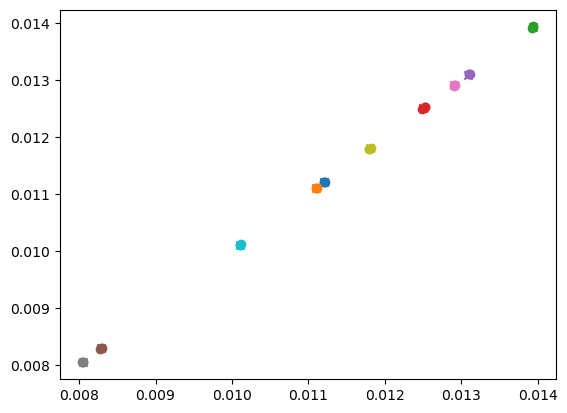

In [101]:
fig, ax = plt.subplots()
# get colorwheel
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
matched = []
for color, (case, controls) in zip(colors, cc_dic.items()):
    matched.extend(controls)
    matched.append(case)
    ax.scatter(df.loc[case, 'ps'], df.loc[case, 'ps'], color = color, marker = 'x')
    ax.scatter(df.loc[controls, 'ps'], df.loc[controls, 'ps'], color = color, marker='o')
unmatched = [i for i in df.index if i not in matched]
#ax.scatter(df.loc[unmatched, 'ps'], df.loc[unmatched, 'ps'], color = 'k', marker='.', alpha=.2)

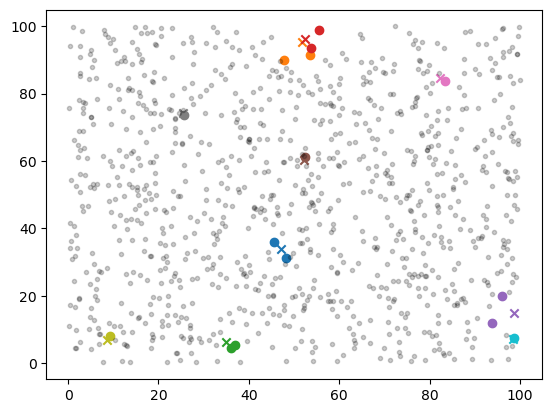

In [81]:
fig, ax = plt.subplots()
# get colorwheel
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
matched = []
for color, (case, controls) in zip(colors, cc_dic.items()):
    matched.extend(controls)
    matched.append(case)
    ax.scatter(df.loc[case, 'age'], df.loc[case, 'bmi'], color = color, marker = 'x')
    ax.scatter(df.loc[controls, 'age'], df.loc[controls, 'bmi'], color = color, marker='o')
unmatched = [i for i in df.index if i not in matched]
ax.scatter(df.loc[unmatched, 'age'], df.loc[unmatched, 'bmi'], color = 'k', marker='.', alpha=.2)

In [ ]:
# distance matrix is n_controlsxn_cases

d:\Thesis\opmatch\opmatch\util\variable_ratio_match.py:75: UserWarning: var_cols not specified, use all df columns, except for case column, to match on.
  warnings.warn('var_cols not specified, use all df columns, except for case column, to match on.')


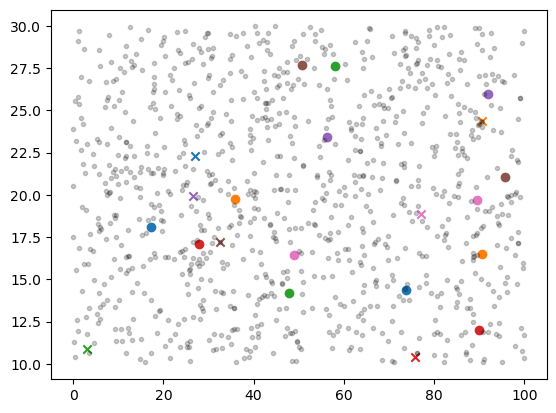

In [5]:
from opmatch import main
case_control_dic = main.match(df=df, matching_ratio=2, metric='Mahalanobis', 
                    matching_type='const')
fig, ax = plt.subplots()
# get colorwheel
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
matched = []
for color, (case, controls) in zip(colors, case_control_dic.items()):
    matched.extend(controls)
    matched.append(case)
    ax.scatter(df.loc[case, 'age'], df.loc[case, 'bmi'], color = color, marker = 'x')
    ax.scatter(df.loc[controls, 'age'], df.loc[controls, 'bmi'], color = color, marker='o')
unmatched = [i for i in df.index if i not in matched]
ax.scatter(df.loc[unmatched, 'age'], df.loc[unmatched, 'bmi'], color = 'k', marker='.', alpha=.2)